In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({'font.size': 24})
plt.rcParams.update({'font.weight': 'bold'})

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None



In [2]:
aloha = pd.read_csv('results/aloha.csv', encoding='latin-1', converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray})


In [3]:
aloha.head()


,run,type,module,name,attrname,attrvalue,value,count,sumweights,mean,stddev,min,max,binedges,binvalues
0,MAM50-MAMRELAY-34-20201118-12:28:32-14761,runattr,NaN,NaN,configname,MAM50-MAMRELAY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
1,MAM50-MAMRELAY-34-20201118-12:28:32-14761,runattr,NaN,NaN,datetime,20201118-12:28:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
2,MAM50-MAMRELAY-34-20201118-12:28:32-14761,runattr,NaN,NaN,experiment,MAM50-MAMRELAY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
3,MAM50-MAMRELAY-34-20201118-12:28:32-14761,runattr,NaN,NaN,inifile,omnetpp.ini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
4,MAM50-MAMRELAY-34-20201118-12:28:32-14761,runattr,NaN,NaN,iterationvars,"$delta=15000, $speedMps=6",NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None


In [4]:
allAttrs = aloha[(aloha.type == 'itervar')]['attrname'].unique()
allAttrs.sort()
allAttrs

array(['delta', 'speedMps'], dtype=object)

In [5]:
allRelayModes = aloha[(aloha['attrname'].str.contains('.app[0].relayMode', na=False, regex=False))]['attrvalue'].unique()
allRelayModes.sort()
allRelayModes

array(['"BMesh"', '"MAM"'], dtype=object)

In [6]:
allSpeeds = aloha[(aloha.attrname == 'speedMps')]['attrvalue'].unique()
allSpeeds.sort()
allSpeeds

array([2.0, 6.0, 14.0], dtype=object)

In [7]:
allDeltas = aloha[(aloha.attrname == 'delta')]['attrvalue'].unique()
allDeltas = allDeltas[allDeltas <= 500]
allDeltas = allDeltas[allDeltas != 2]
allDeltas.sort()
allDeltas

array([0.0, 5.0, 10.0, 20.0, 50.0, 100.0, 500.0], dtype=object)

In [8]:
dataByRun = aloha.groupby(['run'])
dataByRun.size()

run
MAM10-BMRELAY-0-20201118-12:30:41-14865      2551
MAM10-BMRELAY-1-20201118-12:30:42-14865      2551
MAM10-BMRELAY-2-20201118-12:30:42-14865      2551
MAM10-MAMRELAY-0-20201118-12:30:44-14872     2551
MAM10-MAMRELAY-1-20201118-12:30:44-14872     2551
                                            ...  
MAM50-MAMRELAY-5-20201118-12:17:16-14761    11594
MAM50-MAMRELAY-6-20201118-12:17:36-14761    11594
MAM50-MAMRELAY-7-20201118-12:18:04-14761    11593
MAM50-MAMRELAY-8-20201118-12:18:15-14761    11594
MAM50-MAMRELAY-9-20201118-12:18:32-14761    11594
Length: 117, dtype: int64

In [9]:

def findBluetoothRelayRun(speed, configName):
    def testA(x):
        bmeshMatch = x[(x['attrname'].str.contains('.app[0].relayMode', na=False, regex=False))]['attrvalue'].iloc[0] == '"BMesh"'
        speedMatch = x[(x.attrname == 'speedMps')]['attrvalue'].iloc[0] == speed
        configNameMatch = x[(x.attrname == 'configname')]['attrvalue'].iloc[0] == configName
    
        return bmeshMatch & speedMatch & configNameMatch

    s = pd.Series(dataByRun.apply(testA))
    s = s[s == True]
    if len(s) == 0:
        raise Exception("Bluetooth Relay run not found for speed=" + str(speed) + " configName=" + configName)
    if len(s) > 1:
        raise Exception("Bluetooth Relay run duplicate for speed=" + str(speed) + " configName=" + configName)
    return s.index[0]

findBluetoothRelayRun(speed=6, configName='MAM10-BMRELAY')



'MAM10-BMRELAY-1-20201118-12:30:42-14865'

In [10]:

def findMAMRelayRun(speed, delta, configName):
    def testA(x):
        bmeshMatch = x[(x['attrname'].str.contains('.app[0].relayMode', na=False, regex=False))]['attrvalue'].iloc[0] == '"MAM"'
        speedMatch = x[(x.attrname == 'speedMps')]['attrvalue'].iloc[0] == speed
        deltaMatch = x[(x.attrname == 'delta')]['attrvalue'].iloc[0] == delta
        configNameMatch = x[(x.attrname == 'configname')]['attrvalue'].iloc[0] == configName
    
        return bmeshMatch & speedMatch & deltaMatch & configNameMatch

    s = pd.Series(dataByRun.apply(testA))
    s = s[s == True]
    if len(s) == 0:
        raise Exception("MAM Relay run not found for speed=" + str(speed) + " delta=" + str(delta) + " configName=" + configName)
    if len(s) > 1:
        raise Exception("MAM Relay run duplicate for speed=" + str(speed) + " delta=" + str(delta) + " configName=" + configName)
    return s.index[0]

findMAMRelayRun(speed=2, delta=5, configName='MAM50-MAMRELAY')


'MAM50-MAMRELAY-6-20201118-12:17:36-14761'

In [11]:
def getRunData(run):
    return aloha[aloha.run == run]

def getCollectorRunScalars(run):
    runData = aloha[aloha.run == run]
    runData = runData[(runData.type=='scalar')]
    return runData[runData['module'].str.contains('collector1.app')]

getRunData(findBluetoothRelayRun(speed=6, configName='MAM10-BMRELAY'))

,run,type,module,name,attrname,attrvalue,value,count,sumweights,mean,stddev,min,max,binedges,binvalues
6088,MAM10-BMRELAY-1-20201118-12:30:42-14865,runattr,NaN,NaN,configname,MAM10-BMRELAY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
6089,MAM10-BMRELAY-1-20201118-12:30:42-14865,runattr,NaN,NaN,datetime,20201118-12:30:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
6090,MAM10-BMRELAY-1-20201118-12:30:42-14865,runattr,NaN,NaN,experiment,MAM10-BMRELAY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
6091,MAM10-BMRELAY-1-20201118-12:30:42-14865,runattr,NaN,NaN,inifile,omnetpp.ini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
6092,MAM10-BMRELAY-1-20201118-12:30:42-14865,runattr,NaN,NaN,iterationvars,"$delta=0, $speedMps=6",NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580406,MAM10-BMRELAY-1-20201118-12:30:42-14865,histogram,MAM10.collector1.app[0],endToEndDelay:histogram,NaN,None,NaN,201.0,NaN,0.000009,0.000122,0.0,0.001729,"[0.0, 5e-05, 0.0001, 0.00015, 0.0002, 0.00025,...","[200.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
580407,MAM10-BMRELAY-1-20201118-12:30:42-14865,attr,MAM10.collector1.app[0],endToEndDelay:histogram,interpolationmode,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
580408,MAM10-BMRELAY-1-20201118-12:30:42-14865,attr,MAM10.collector1.app[0],endToEndDelay:histogram,source,dataAge(packetReceived),NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
580409,MAM10-BMRELAY-1-20201118-12:30:42-14865,attr,MAM10.collector1.app[0],endToEndDelay:histogram,title,"end-to-end delay, histogram",NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None


In [12]:
aloha.iloc[1200:1205]


,run,type,module,name,attrname,attrvalue,value,count,sumweights,mean,stddev,min,max,binedges,binvalues
1200,MAM50-MAMRELAY-7-20201118-12:18:04-14761,param,NaN,NaN,*.host*.wlan[0].radio.energyConsumer.receiverI...,2mW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
1201,MAM50-MAMRELAY-7-20201118-12:18:04-14761,param,NaN,NaN,*.host*.wlan[0].radio.energyConsumer.receiverB...,5mW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
1202,MAM50-MAMRELAY-7-20201118-12:18:04-14761,param,NaN,NaN,*.host*.wlan[0].radio.energyConsumer.receiverR...,10mW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
1203,MAM50-MAMRELAY-7-20201118-12:18:04-14761,param,NaN,NaN,*.host*.wlan[0].radio.energyConsumer.transmitt...,2mW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
1204,MAM50-MAMRELAY-7-20201118-12:18:04-14761,param,NaN,NaN,*.host*.wlan[0].radio.energyConsumer.transmitt...,100mW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None


In [13]:
aloha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613303 entries, 0 to 613302
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   run         613303 non-null  object 
 1   type        613303 non-null  object 
 2   module      603976 non-null  object 
 3   name        603976 non-null  object 
 4   attrname    425262 non-null  object 
 5   attrvalue   425262 non-null  object 
 6   value       174488 non-null  float64
 7   count       13512 non-null   float64
 8   sumweights  0 non-null       float64
 9   mean        7870 non-null    float64
 10  stddev      7780 non-null    float64
 11  min         7870 non-null    float64
 12  max         7870 non-null    float64
 13  binedges    10950 non-null   object 
 14  binvalues   10950 non-null   object 
dtypes: float64(7), object(8)
memory usage: 70.2+ MB


In [14]:
aloha.describe()

,value,count,sumweights,mean,stddev,min,max
count,1.744880e+05,13512.000000,0.0,7870.000000,7780.000000,7870.000000,7.870000e+03
mean,8.925807e+03,5732.127368,NaN,310.609171,inf,1.247769,2.363025e+04
std,1.357980e+05,13628.443353,NaN,2512.231190,NaN,8.465610,1.031737e+05
min,-4.750747e+00,0.000000,NaN,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000e+00,0.000000,NaN,0.031583,0.103634,0.000000,4.989569e-01
50%,0.000000e+00,575.500000,NaN,0.117644,0.308664,0.000000,1.000000e+00
75%,1.270000e+02,7417.000000,NaN,61.366343,179.907329,0.000353,1.529271e+03
max,2.092755e+07,89342.000000,NaN,98558.050476,inf,145.029571,1.453366e+06


In [15]:
scalars = aloha[(aloha.type=='scalar')]
scalars.head()


,run,type,module,name,attrname,attrvalue,value,count,sumweights,mean,stddev,min,max,binedges,binvalues
9327,MAM10-BMRELAY-2-20201118-12:30:42-14865,scalar,MAM10.radioMedium.propagation,Arrival computation count,NaN,None,28560.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None
9328,MAM10-BMRELAY-2-20201118-12:30:42-14865,scalar,MAM10.radioMedium,transmission count,NaN,None,2856.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None
9329,MAM10-BMRELAY-2-20201118-12:30:42-14865,scalar,MAM10.radioMedium,signal send count,NaN,None,28560.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None
9330,MAM10-BMRELAY-2-20201118-12:30:42-14865,scalar,MAM10.radioMedium,reception computation count,NaN,None,28560.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None
9331,MAM10-BMRELAY-2-20201118-12:30:42-14865,scalar,MAM10.radioMedium,interference computation count,NaN,None,69341.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None


In [16]:
runPrefix = 'MAM50-BMRELAY-0'
run2Prefix = 'MAM50-MAMRELAY-6'

In [17]:
def getScalarSum(scalarName, runData):
    scalarData = runData[(runData.type=='scalar')]
    return scalarData[(scalarData.name==scalarName)]['value'].sum()

energyConsumptionSum = getScalarSum(scalarName='residualEnergyCapacity:last', 
                        runData=getRunData(findBluetoothRelayRun(speed=2, configName='MAM50-BMRELAY')))
energyConsumptionSum

-104.30051641048087

In [18]:
energyConsumption2Sum = getScalarSum(scalarName='residualEnergyCapacity:last', 
                        runData=getRunData(findMAMRelayRun(speed=2, delta=10, configName='MAM50-MAMRELAY')))
energyConsumption2Sum

-25.249505379005466

In [19]:
def getUniqueScalarValue(scalarName, scalarData):
    scalarValue = scalarData[(scalarData.name==scalarName)]['value']

    if len(scalarValue) > 1:
        raise Exception('Scalar ' + scalarName + ' is not unique on this dataframe')
    return scalarValue.iloc[0]

collectorPacketsReceived = getUniqueScalarValue(scalarName='packetReceived:count', 
                        scalarData=getCollectorRunScalars(findBluetoothRelayRun(speed=2, configName='MAM50-BMRELAY')))

'Packets received (BM 2): ' + str(collectorPacketsReceived)

'Packets received (BM 2): 12580.0'

In [20]:
collectorPacketsReceived2 = getUniqueScalarValue(scalarName='packetReceived:count', 
                        scalarData=getCollectorRunScalars(findMAMRelayRun(speed=2, delta=10, configName='MAM50-MAMRELAY')))

'Packets received (MAM 2 D5): ' + str(collectorPacketsReceived2)

'Packets received (MAM 2 D5): 1798.0'

In [21]:
dataPacketsSent = getScalarSum('data packets sent', getRunData(findBluetoothRelayRun(speed=2, configName='MAM50-BMRELAY')))
dataPacketsSent2 = getScalarSum('data packets sent', getRunData(findMAMRelayRun(speed=2, delta=10, configName='MAM50-MAMRELAY')))

'Data packets sent (BM 2): ' + str(dataPacketsSent) + ' / Data packets sent (MAM 2 D5): ' + str(dataPacketsSent2)

'Data packets sent (BM 2): 413966.0 / Data packets sent (MAM 2 D5): 2124.0'

In [22]:
'Data packets sent (' + run2Prefix + '): ' + str(dataPacketsSent2)

'Data packets sent (MAM50-MAMRELAY-6): 2124.0'

In [23]:
histograms = aloha[aloha.type=='histogram']
endToEndDelayHistograms = histograms[aloha.name=='realDataEndToEndDelay:histogram']
len(endToEndDelayHistograms)


<ipython-input-23-5a1b8474be2b>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  endToEndDelayHistograms = histograms[aloha.name=='realDataEndToEndDelay:histogram']


117

In [24]:
def getHistogramData(histogramName, runData):
    histograms = runData[runData.type == 'histogram']
    histogram = histograms[histograms.name == histogramName]
    if len(histogram) == 0:
        raise Exception('Histogram not found')
    if len(histogram) > 1:
        raise Exception('Histogram match not unique')
    return histogram.iloc[0]

hist = getHistogramData(histogramName='realDataEndToEndDelay:histogram', 
                        runData=getRunData(findBluetoothRelayRun(speed=2, configName='MAM50-BMRELAY')))
hist

run                     MAM50-BMRELAY-0-20201118-12:00:10-14640
type                                                  histogram
module                                 MAM200.collector1.app[0]
name                            realDataEndToEndDelay:histogram
attrname                                                    NaN
attrvalue                                                  None
value                                                       NaN
count                                                     12091
sumweights                                                  NaN
mean                                                    29.6907
stddev                                                  20.1663
min                                                     1.00938
max                                                     128.992
binedges      [0.0, 1.6, 3.2, 4.8, 6.4, 8.0, 9.6, 11.2, 12.8...
binvalues     [160.0, 261.0, 370.0, 376.0, 408.0, 385.0, 390...
Name: 587813, dtype: object

In [25]:
hist2 = getHistogramData(histogramName='realDataEndToEndDelay:histogram', 
                        runData=getRunData(findMAMRelayRun(speed=2, delta=10, configName='MAM50-MAMRELAY')))
hist2

run                    MAM50-MAMRELAY-9-20201118-12:18:32-14761
type                                                  histogram
module                                 MAM200.collector1.app[0]
name                            realDataEndToEndDelay:histogram
attrname                                                    NaN
attrvalue                                                  None
value                                                       NaN
count                                                      1439
sumweights                                                  NaN
mean                                                     31.618
stddev                                                  19.1951
min                                                     1.01124
max                                                     65.2244
binedges      [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...
binvalues     [0.0, 32.0, 29.0, 27.0, 25.0, 23.0, 27.0, 28.0...
Name: 591545, dtype: object

In [26]:
hist2.binedges, hist2.binvalues

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
        65., 66.]),
 array([ 0., 32., 29., 27., 25., 23., 27., 28., 27., 25., 31., 28., 24.,
        28., 16., 27., 23., 17., 23., 19., 25., 19., 21., 22., 17., 19.,
        23., 18., 24., 22., 20., 18., 20., 21., 19., 13., 18., 20., 20.,
        28., 29., 23., 19., 21., 27., 23., 23., 24., 23., 19., 17., 16.,
        19., 18., 24., 18., 22., 23., 22., 25., 23., 11., 21., 25., 25.,
        13.]))

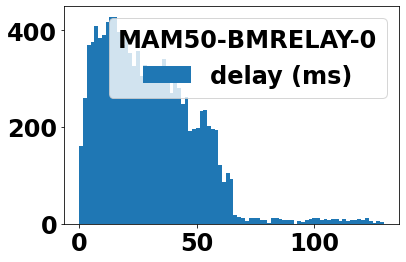

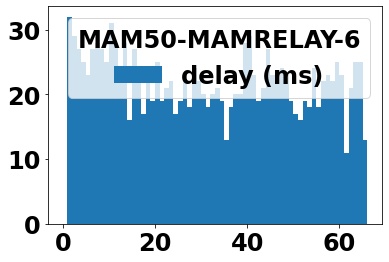

In [27]:

plt.hist(bins=hist.binedges, x=hist.binedges[:-1], weights=hist.binvalues, label="delay (ms)")
plt.legend(title=runPrefix)
plt.show()

plt.hist(bins=hist2.binedges, x=hist2.binedges[:-1], weights=hist2.binvalues, label="delay (ms)")
plt.legend(title=run2Prefix)
plt.show()

In [28]:
hist = endToEndDelayHistograms[endToEndDelayHistograms['run'].str.startswith(runPrefix, na=False)].iloc[0]
hist

run                     MAM50-BMRELAY-0-20201118-12:00:10-14640
type                                                  histogram
module                                 MAM200.collector1.app[0]
name                            realDataEndToEndDelay:histogram
attrname                                                    NaN
attrvalue                                                  None
value                                                       NaN
count                                                     12091
sumweights                                                  NaN
mean                                                    29.6907
stddev                                                  20.1663
min                                                     1.00938
max                                                     128.992
binedges      [0.0, 1.6, 3.2, 4.8, 6.4, 8.0, 9.6, 11.2, 12.8...
binvalues     [160.0, 261.0, 370.0, 376.0, 408.0, 385.0, 390...
Name: 587813, dtype: object

In [29]:
str(100-energyConsumption2Sum/energyConsumptionSum*100) + '% ' + run2Prefix + ' energy efficiency compared to ' + runPrefix

'75.79158162589096% MAM50-MAMRELAY-6 energy efficiency compared to MAM50-BMRELAY-0'

,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,BTM-R ★,0.0,12.8,25.6,41.6,84.8
1,MAM-0,0.0,14.0,30.0,48.0,90.0
2,MAM-Δ=5.0,1.0,15.0,31.0,47.0,65.0
3,MAM-Δ=10.0,1.0,14.0,31.0,48.0,65.0
4,MAM-Δ=20.0,1.0,15.0,33.0,48.0,65.0
5,MAM-Δ=50.0,1.0,15.0,30.0,47.0,65.0
6,MAM-Δ=100.0,1.0,15.0,31.0,48.0,65.0
7,MAM-Δ=500.0,1.0,15.0,31.0,47.0,65.0


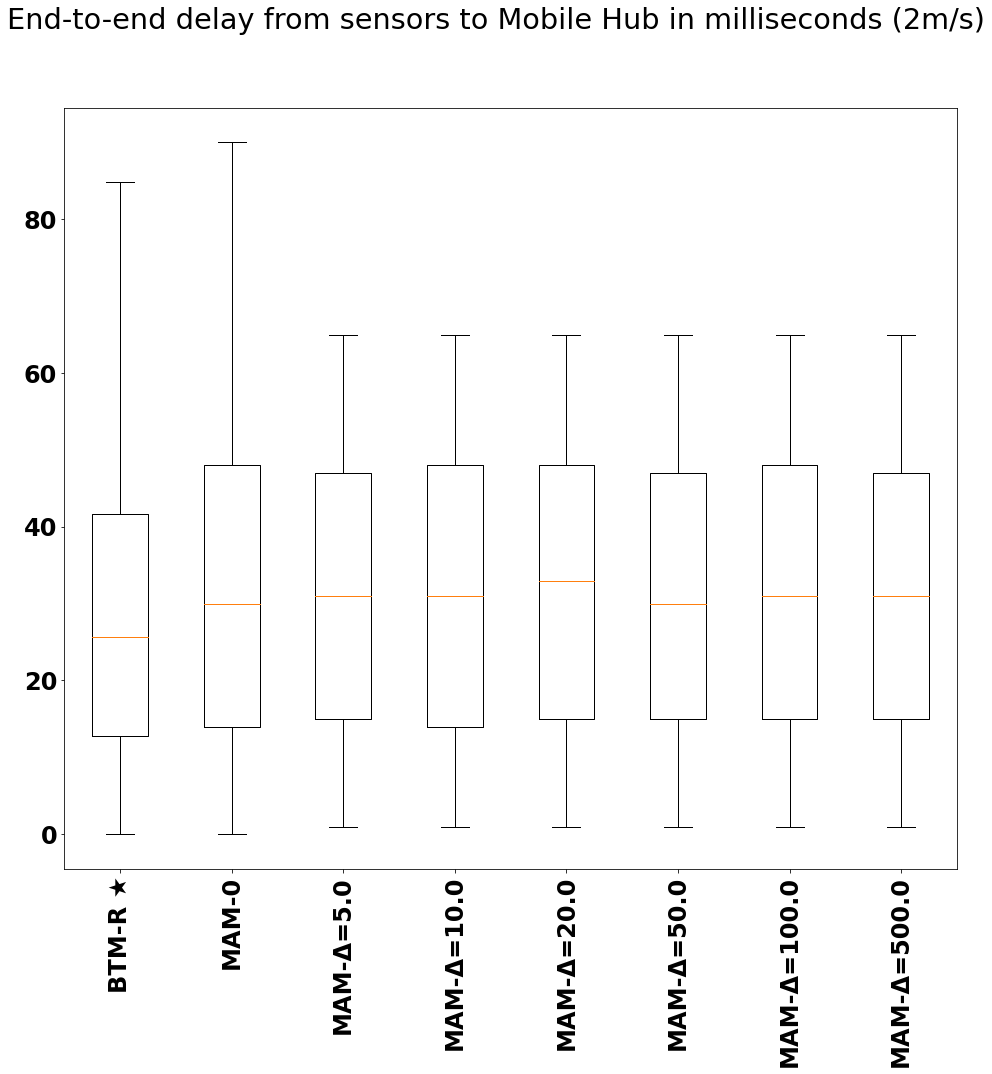

In [30]:
def explodeHistogramData(histogram):
    a = []

    i = 0
    for aa in histogram.binedges[:-1]:
        for j in range(1,histogram.binvalues[i].astype(np.int)):
            a.append(aa)
        i = i + 1
    return a

def getBoxPlotData(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)

# Create a figure instance
fig = plt.figure(1, figsize=(16, 14))

# Create an axes instance
ax = fig.add_subplot(111)

bmesh2mpsData = explodeHistogramData(getHistogramData(histogramName='realDataEndToEndDelay:histogram', 
                        runData=getRunData(findBluetoothRelayRun(speed=2, configName='MAM50-BMRELAY'))))
    
data_to_plot_2ms = [bmesh2mpsData]
labels = ['BTM-R ★']

for d in allDeltas:
    data_to_plot_2ms.append(explodeHistogramData(getHistogramData(histogramName='realDataEndToEndDelay:histogram', 
                        runData=getRunData(findMAMRelayRun(speed=2, delta=d, configName='MAM50-MAMRELAY')))))
    if d == 0:
        labels.append('MAM-0')
    else:
        labels.append('MAM-Δ=' + str(d))

# Create the boxplot
bp = ax.boxplot(data_to_plot_2ms, showfliers=False)

ax.set_xticklabels(labels)

speed = 2
plt.suptitle('End-to-end delay from sensors to Mobile Hub in milliseconds (' + str(speed) + 'm/s)')

plt.xticks(rotation='90.0')

# Save the figure
fig.savefig('fig1.png', bbox_inches='tight', dpi=150)

getBoxPlotData(labels, bp)

,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,BTM-R ★,0.8,5.6,10.4,15.20,28.8
1,MAM-0,1.0,4.0,8.0,13.00,21.0
2,MAM-Δ=5.0,1.0,5.0,9.0,14.00,21.0
3,MAM-Δ=10.0,1.0,4.0,8.5,14.75,21.0
4,MAM-Δ=20.0,1.0,5.0,9.0,14.00,23.5
5,MAM-Δ=50.0,1.0,4.0,8.0,13.50,21.0
6,MAM-Δ=100.0,1.0,4.0,8.5,14.00,21.0
7,MAM-Δ=500.0,1.0,5.0,9.0,14.00,21.0


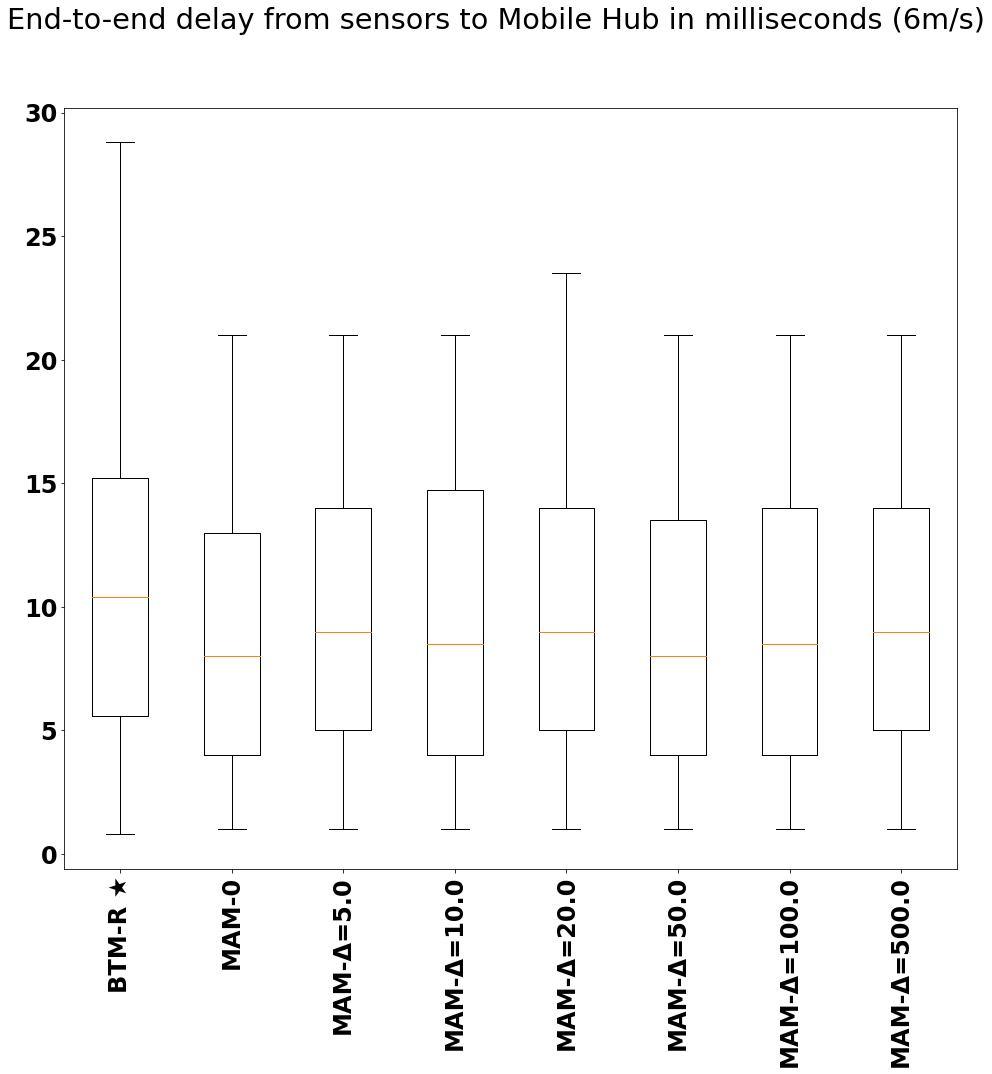

In [31]:
# Create a figure instance
fig = plt.figure(1, figsize=(16, 14))

# Create an axes instance
ax = fig.add_subplot(111)

bmesh6mpsData = explodeHistogramData(getHistogramData(histogramName='realDataEndToEndDelay:histogram', 
                        runData=getRunData(findBluetoothRelayRun(speed=6, configName='MAM50-BMRELAY'))))

data_to_plot_6ms = [bmesh6mpsData]
labels = ['BTM-R ★']

for d in allDeltas:
    data_to_plot_6ms.append(explodeHistogramData(getHistogramData(histogramName='realDataEndToEndDelay:histogram', 
                        runData=getRunData(findMAMRelayRun(speed=6, delta=d, configName='MAM50-MAMRELAY')))))
    if d == 0:
        labels.append('MAM-0')
    else:
        labels.append('MAM-Δ=' + str(d))

# Create the boxplot
bp = ax.boxplot(data_to_plot_6ms, showfliers=False)

ax.set_xticklabels(labels)

speed = 6
plt.suptitle('End-to-end delay from sensors to Mobile Hub in milliseconds (' + str(speed) + 'm/s)')

plt.xticks(rotation='90.0')

# Save the figure
fig.savefig('fig2.png', bbox_inches='tight', dpi=150)

getBoxPlotData(labels, bp)

,label,lower_whisker,lower_quartile,median,upper_quartile,upper_whisker
0,BTM-R ★,145.6,158.6,166.4,176.8,192.4
1,MAM-0,150.0,155.0,165.0,175.0,185.0
2,MAM-Δ=5.0,150.0,155.0,165.0,175.0,185.0
3,MAM-Δ=10.0,150.0,155.0,165.0,175.0,185.0
4,MAM-Δ=20.0,150.0,155.0,165.0,175.0,185.0
5,MAM-Δ=50.0,150.0,155.0,165.0,175.0,195.0
6,MAM-Δ=100.0,150.0,155.0,165.0,175.0,185.0
7,MAM-Δ=500.0,150.0,155.0,165.0,175.0,195.0


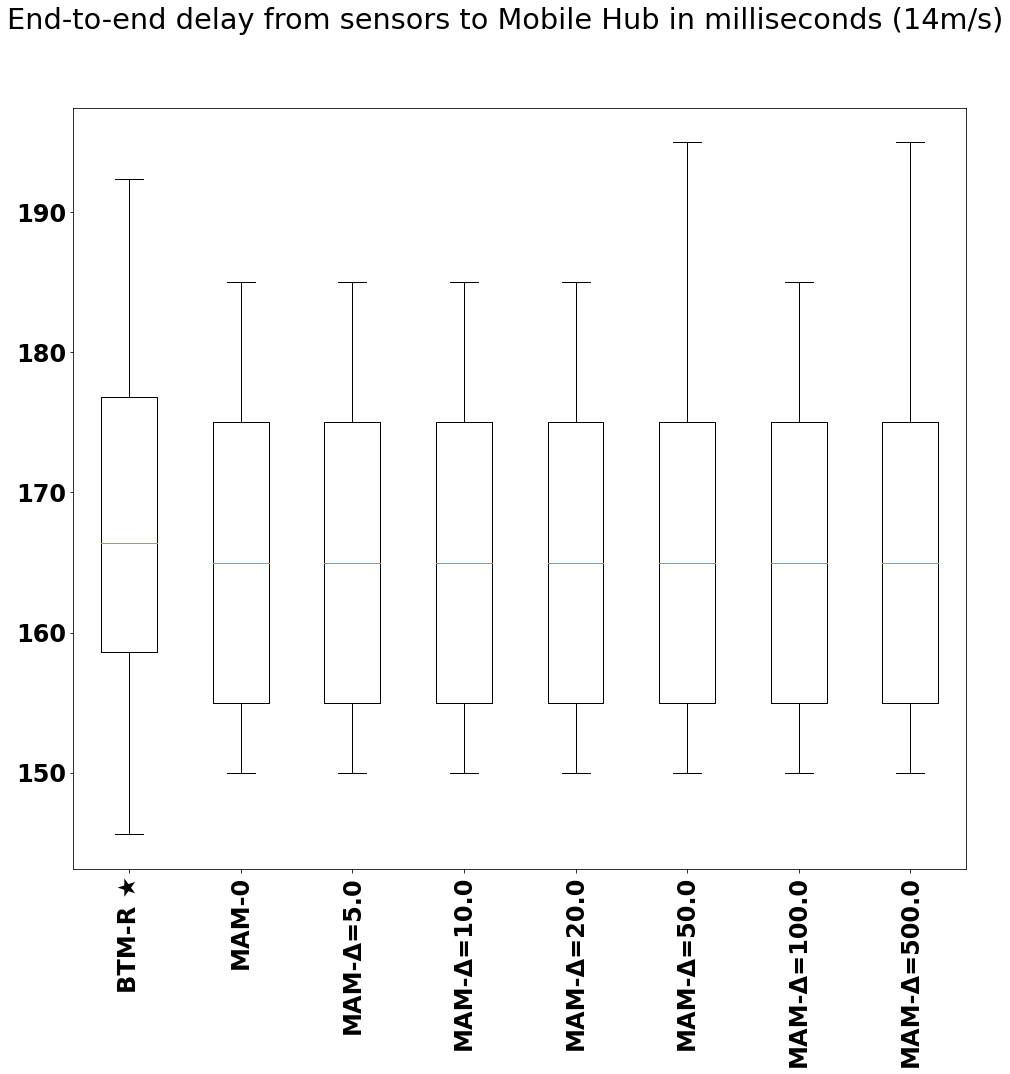

In [32]:
bmesh14mpsData = explodeHistogramData(getHistogramData(histogramName='realDataEndToEndDelay:histogram', 
                        runData=getRunData(findBluetoothRelayRun(speed=14, configName='MAM50-BMRELAY'))))
    
    
# Create a figure instance
fig = plt.figure(1, figsize=(16, 14))

# Create an axes instance
ax = fig.add_subplot(111)

data_to_plot_14ms = [bmesh14mpsData]
labels = ['BTM-R ★']

for d in allDeltas:
    data_to_plot_14ms.append(explodeHistogramData(getHistogramData(histogramName='realDataEndToEndDelay:histogram', 
                        runData=getRunData(findMAMRelayRun(speed=14, delta=d, configName='MAM50-MAMRELAY')))))
    if d == 0:
        labels.append('MAM-0')
    else:
        labels.append('MAM-Δ=' + str(d))

# Create the boxplot
bp = ax.boxplot(data_to_plot_14ms, showfliers=False)

ax.set_xticklabels(labels)

speed = 14
plt.suptitle('End-to-end delay from sensors to Mobile Hub in milliseconds (' + str(speed) + 'm/s)')


plt.xticks(rotation='90.0')

# Save the figure
fig.savefig('fig3.png', bbox_inches='tight', dpi=150)

getBoxPlotData(labels, bp)

In [33]:
def getEnergyConsumptionData(speed):
    energyConsumptionSumBM = getScalarSum(scalarName='residualEnergyCapacity:last', 
                            runData=getRunData(findBluetoothRelayRun(speed=speed, configName='MAM50-BMRELAY')))


    labels = ['BTM-R ★']
    values = [-energyConsumptionSum]

    for d in allDeltas:
        values.append(-getScalarSum(scalarName='residualEnergyCapacity:last', 
                            runData=getRunData(findMAMRelayRun(speed=speed, delta=d, configName='MAM50-MAMRELAY'))))
        if d == 0:
            labels.append('MAM-0')
        else:
            labels.append('MAM-Δ=' + str(d))
    return [labels, values]

def getBarChartData(labels, values):
    rows_list = []
    
    isDict = type(values) is dict
    
    if not isDict:
        for i in range(len(labels)):
            dict1 = {}
            dict1['label'] = labels[i]
            dict1['value'] = values[i]

            rows_list.append(dict1)
    else:
        for key in values:
            row = values[key]
            
            i = 0
            for ld in labels:
                dict1 = {}
                dict1['label'] = key + " - " + ld[0]
                dict1['value'] = row[i]
                rows_list.append(dict1)
                i = i + 1
        
    return pd.DataFrame(rows_list)

[labels, values] = getEnergyConsumptionData(2)
getBarChartData(labels, values)

,label,value
0,BTM-R ★,104.300516
1,MAM-0,24.743542
2,MAM-Δ=5.0,25.163760
3,MAM-Δ=10.0,25.249505
4,MAM-Δ=20.0,25.125269
5,MAM-Δ=50.0,24.712576
6,MAM-Δ=100.0,24.993877
7,MAM-Δ=500.0,25.041143


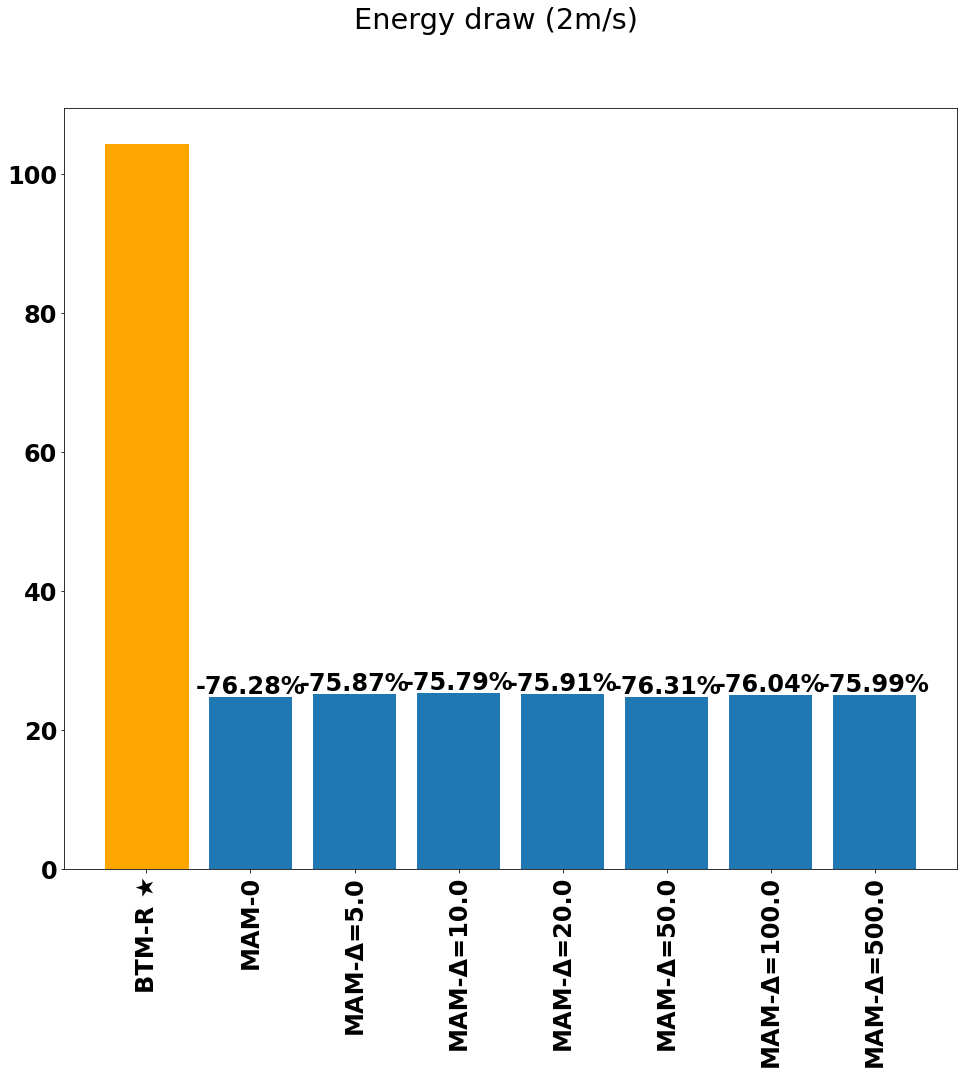

In [34]:
def plotEnergyConsumptionData(labels, values, speed, imageIdx):
    # Create a figure instance
    fig = plt.figure(1, figsize=(16, 14))

    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the barchart
    bp = ax.bar(labels, values)
    bp[0].set_color('orange')
        
    i = 0
    for p in bp.patches:
        if i > 0:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy() 
            perc = (values[i]-values[0])/values[0]
            ax.annotate(f'{perc:.2%}', (x + width/2, y + height*1.02), ha='center')
        i = i + 1

    plt.suptitle('Energy draw (' + str(speed) + 'm/s)')
    plt.xticks(rotation='90.0')

    # Save the figure
    fig.savefig('fig' + str(imageIdx) + '.png', bbox_inches='tight', dpi=150)
    
plotEnergyConsumptionData(labels, values, 2, 4)

In [35]:
[labels, values] = getEnergyConsumptionData(6)
getBarChartData(labels, values)

,label,value
0,BTM-R ★,104.300516
1,MAM-0,22.109443
2,MAM-Δ=5.0,21.682270
3,MAM-Δ=10.0,22.085478
4,MAM-Δ=20.0,22.226712
5,MAM-Δ=50.0,22.510511
6,MAM-Δ=100.0,21.970149
7,MAM-Δ=500.0,22.343854


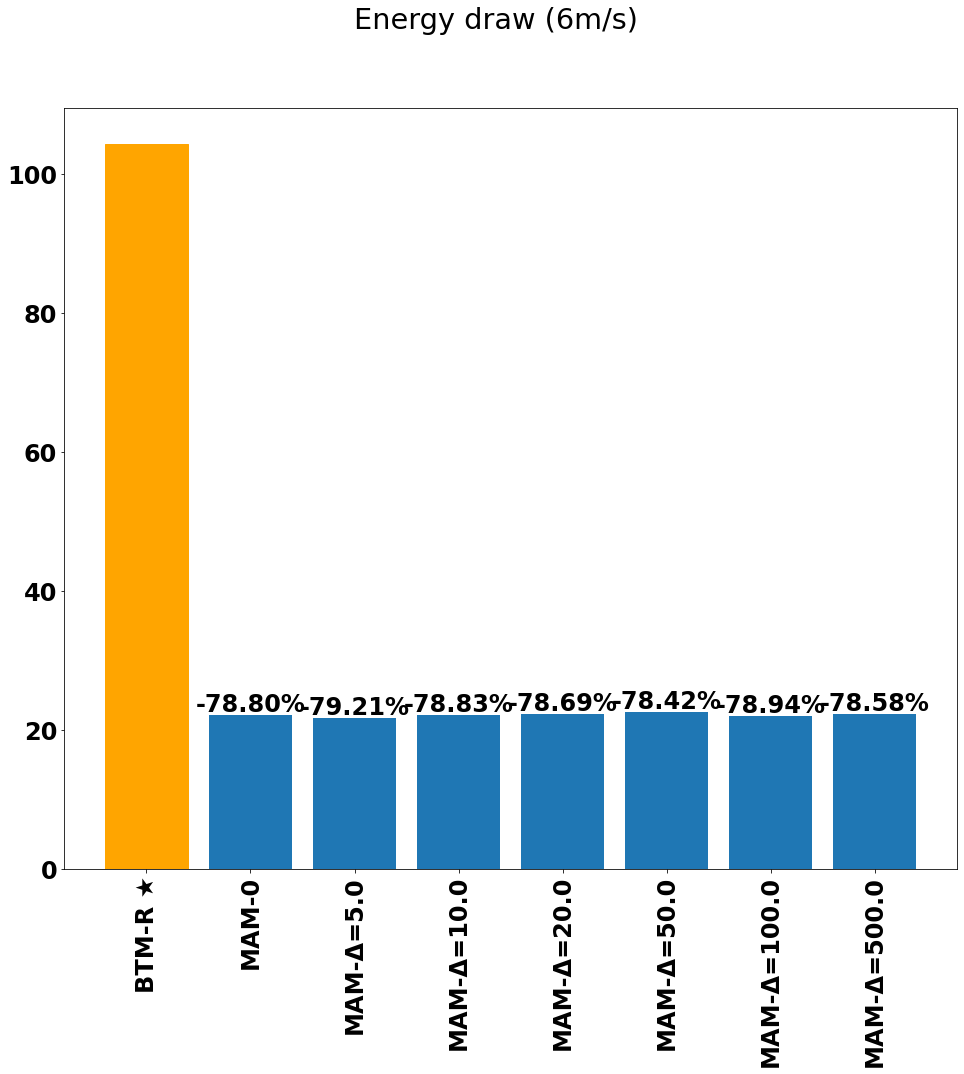

In [36]:
plotEnergyConsumptionData(labels, values, 6, 5)

In [37]:
[labels, values] = getEnergyConsumptionData(14)
getBarChartData(labels, values)

,label,value
0,BTM-R ★,104.300516
1,MAM-0,23.696085
2,MAM-Δ=5.0,23.197066
3,MAM-Δ=10.0,23.286197
4,MAM-Δ=20.0,23.440371
5,MAM-Δ=50.0,23.686578
6,MAM-Δ=100.0,23.222256
7,MAM-Δ=500.0,23.494161


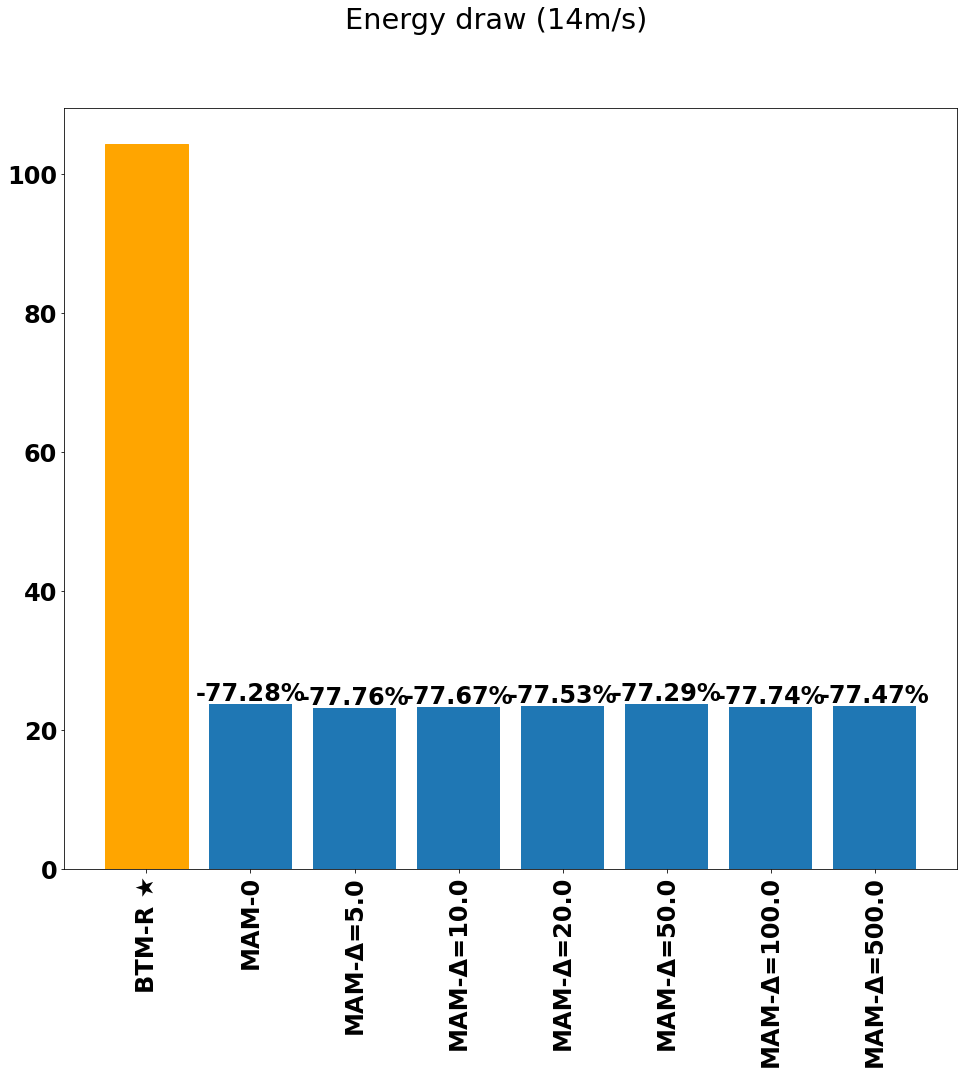

In [38]:
plotEnergyConsumptionData(labels, values, 14, 6)

In [39]:
def getCollectorPacketsReceivedData(speed):
    bmData = getUniqueScalarValue(scalarName='unique data packets bytes received', 
                            scalarData=getCollectorRunScalars(findBluetoothRelayRun(speed=speed, configName='MAM50-BMRELAY')))

    bmRepeatedData = getUniqueScalarValue(scalarName='repeated data packets bytes received', 
                            scalarData=getCollectorRunScalars(findBluetoothRelayRun(speed=speed, configName='MAM50-BMRELAY')))

    labels = [['unique',u'#348ABD'], ['repeated',u'#A60628']]
    values = dict()
    values['BTM-R ★'] = [bmData, bmRepeatedData]
    #repeatedValues = [bmRepeatedData]

    for d in allDeltas:
        data = getUniqueScalarValue(scalarName='unique data packets bytes received', 
                            scalarData=getCollectorRunScalars(findMAMRelayRun(speed=speed, delta=d, configName='MAM50-MAMRELAY')))
        repeatedData = getUniqueScalarValue(scalarName='repeated data packets bytes received', 
                            scalarData=getCollectorRunScalars(findMAMRelayRun(speed=speed, delta=d, configName='MAM50-MAMRELAY')))
        
        if d == 0:
            values['MAM-0'] = [data,repeatedData]
        else:
            values['MAM-Δ=' + str(d)] = [data,repeatedData]
    return [labels, values]

def plotPacketsReceivedData(labels, values, speed, imageIdx):
    # Create a figure instance
    fig = plt.figure(1, figsize=(16, 14))
    
    # Create an axes instance
    ax = fig.add_subplot(111)

    ax.set_xticklabels([], fontsize = 24)

    bp = []
    
    # Create the barchart
    i = 0
    for key,vals in values.items():
        j = len(vals)
        temp = sum(vals)
        for val in reversed(vals):
            tempBp = ax.bar(i, temp, color=labels[j - 1][1])
            
            if j == len(vals):
                bp.append(tempBp) # Only add the sum to the bp patches
            
            temp = temp - val
            j = j - 1
        i = i + 1


    labelNames = list()
    colors = dict()
    for labelData in labels:
        labelNames.append(labelData[0])
        colors[labelData[0]] = labelData[1]
        
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labelNames]
    plt.legend(handles, labelNames, prop={'weight': 'bold', 'size': 24})

    #bp[0].set_color('orange')
    
    i = 0
    for c in bp:
        for p in c.patches:
            if i > 0:
                width = p.get_width()
                height = p.get_height()
                x, y = p.get_xy() 
                vvalues = list(values.values())
                perc = (sum(vvalues[i])-(vvalues[0][0]))/(vvalues[0][0])
                ax.annotate(f'{perc:.2%}', (x + width/2, y + height*1.02), ha='center')
            i = i + 1

    plt.suptitle('M-Hub Received packets in bytes (' + str(speed) + 'm/s)', fontproperties={'weight': 'bold', 'size': 24})
    plt.xticks(range(len(values)), values.keys(), rotation='90.0')

    # Save the figure
    fig.savefig('fig' + str(imageIdx) + '.png', bbox_inches='tight', dpi=150)
    


In [40]:
[labels, values] = getCollectorPacketsReceivedData(2)


In [41]:
getBarChartData(labels, values)

,label,value
0,BTM-R ★ - unique,32912.0
1,BTM-R ★ - repeated,100089.0
2,MAM-0 - unique,15301.0
3,MAM-0 - repeated,0.0
4,MAM-Δ=5.0 - unique,15741.0
5,MAM-Δ=5.0 - repeated,0.0
6,MAM-Δ=10.0 - unique,15829.0
7,MAM-Δ=10.0 - repeated,0.0
8,MAM-Δ=20.0 - unique,16379.0
9,MAM-Δ=20.0 - repeated,0.0


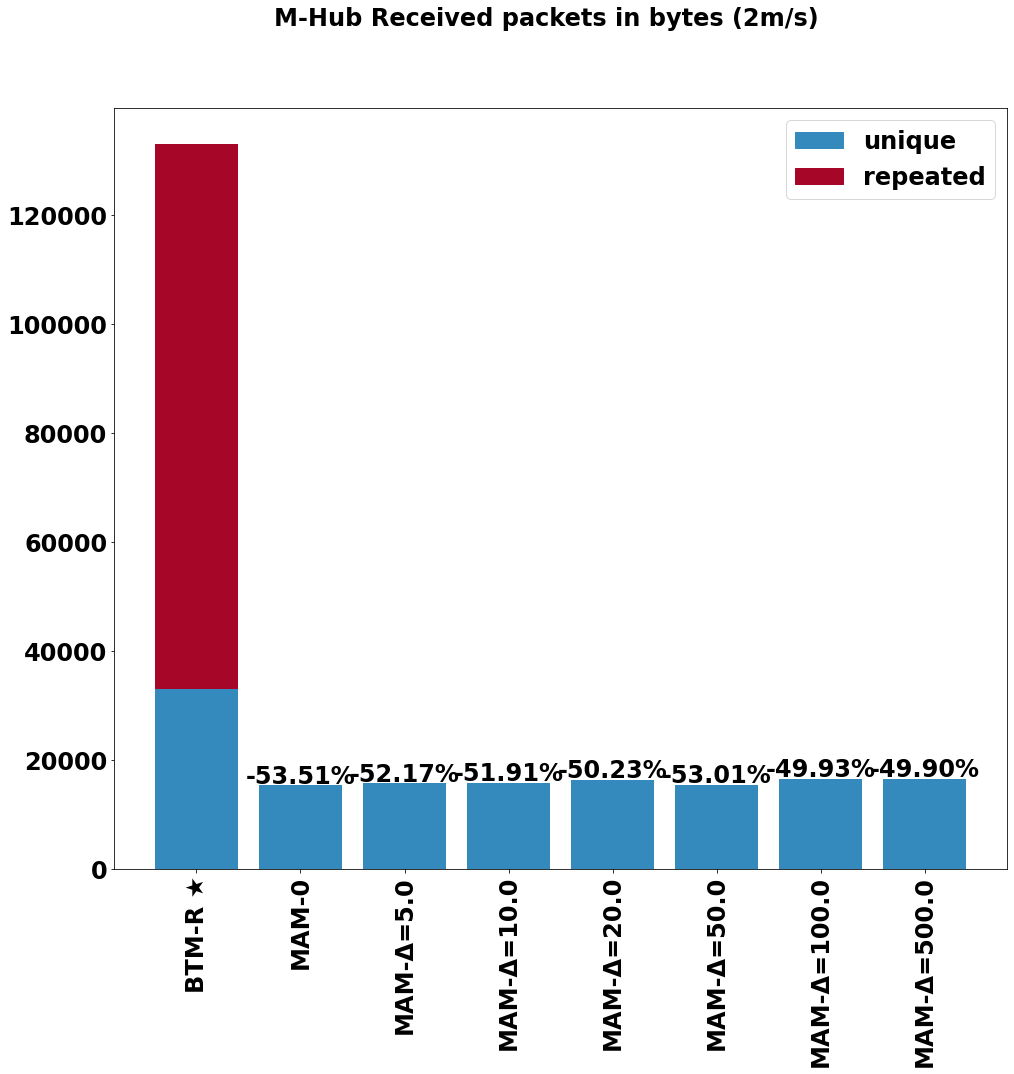

In [42]:
plotPacketsReceivedData(labels, values, 2, 7)

In [43]:
[labels, values] = getCollectorPacketsReceivedData(6)
getBarChartData(labels, values)

,label,value
0,BTM-R ★ - unique,13112.0
1,BTM-R ★ - repeated,22990.0
2,MAM-0 - unique,4169.0
3,MAM-0 - repeated,0.0
4,MAM-Δ=5.0 - unique,4268.0
5,MAM-Δ=5.0 - repeated,0.0
6,MAM-Δ=10.0 - unique,4554.0
7,MAM-Δ=10.0 - repeated,0.0
8,MAM-Δ=20.0 - unique,4444.0
9,MAM-Δ=20.0 - repeated,0.0


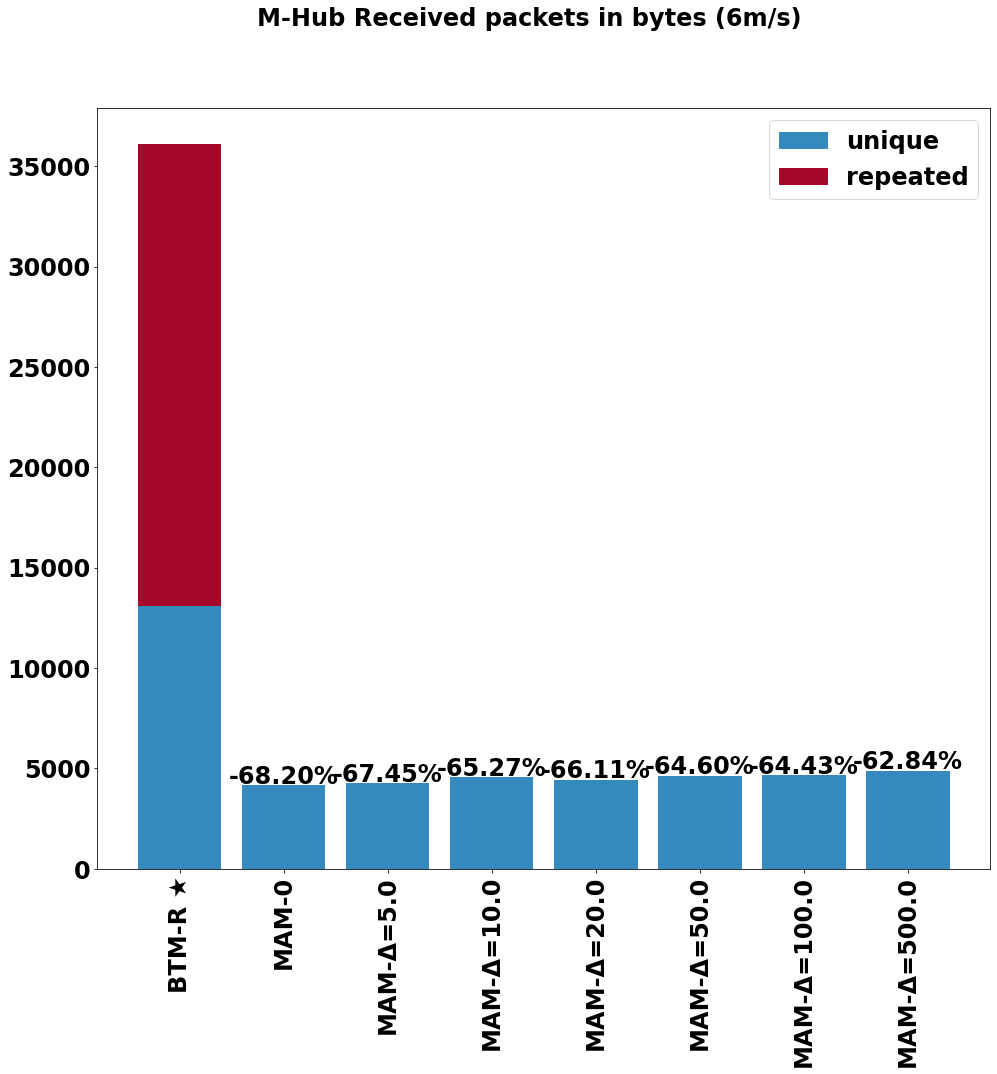

In [44]:
plotPacketsReceivedData(labels, values, 6, 8)

In [45]:
[labels, values] = getCollectorPacketsReceivedData(14)
getBarChartData(labels, values)

,label,value
0,BTM-R ★ - unique,24189.0
1,BTM-R ★ - repeated,86592.0
2,MAM-0 - unique,11044.0
3,MAM-0 - repeated,0.0
4,MAM-Δ=5.0 - unique,10692.0
5,MAM-Δ=5.0 - repeated,0.0
6,MAM-Δ=10.0 - unique,10472.0
7,MAM-Δ=10.0 - repeated,0.0
8,MAM-Δ=20.0 - unique,11363.0
9,MAM-Δ=20.0 - repeated,0.0


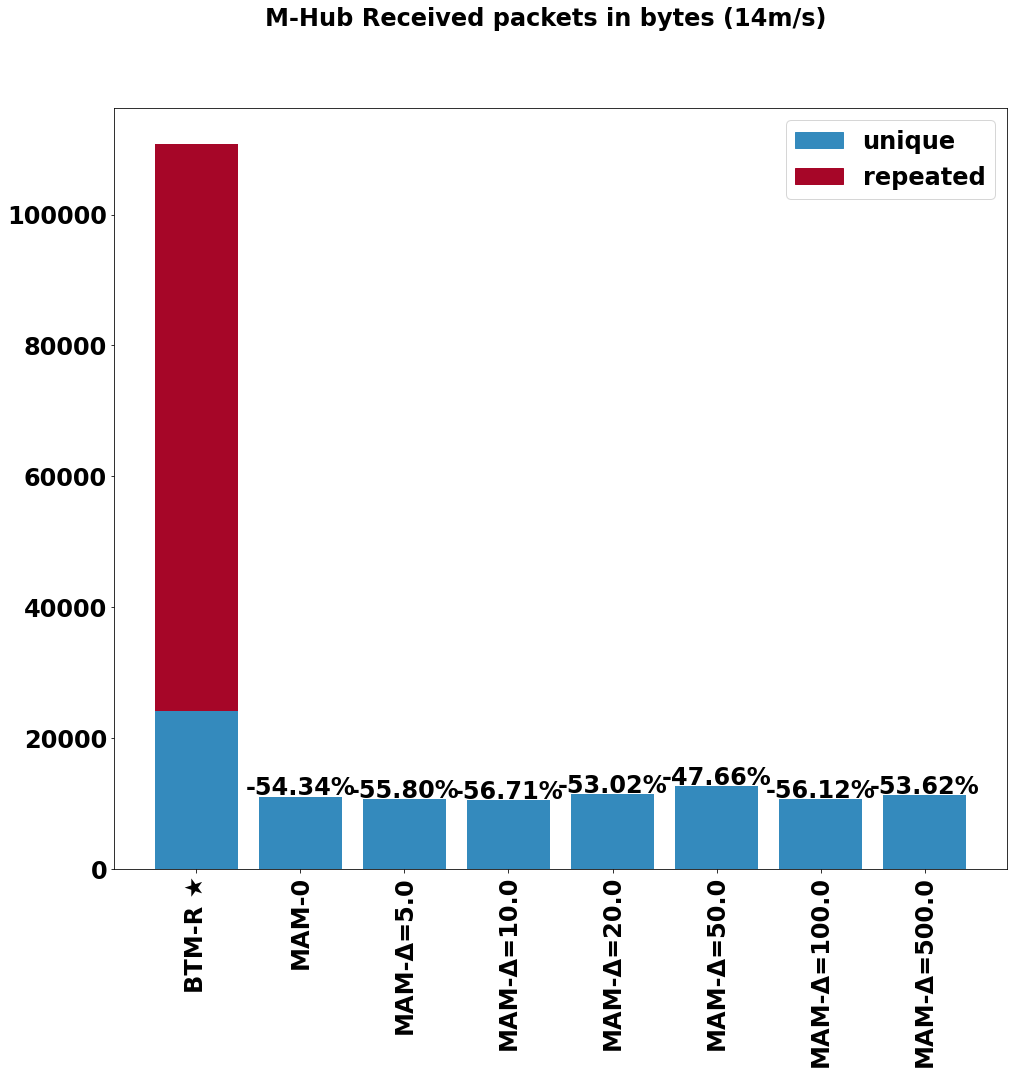

In [46]:
plotPacketsReceivedData(labels, values, 14, 9)

In [48]:
def getReceivedPacketUUIDs(runData):
    packetUUIDs = set()

    data = runData[runData['name'].str.contains("received packet uuids-part1", na=False)]

    i = 1
    while len(data) > 0:
        if len(data) > 1:
            raise Exception('Error - non unique uuid part')

        key = data.iloc[0]['name']
        uuidsPartial = key.split('=')[1].split(',')
        packetUUIDs.update(uuidsPartial)
        i = i + 1
        data = runData[runData['name'].str.contains("received packet uuids-part" + str(i), na=False)]

    return packetUUIDs

def getGeneratedPacketUUIDs(runData):
    packetUUIDs = set()

    #data = runData[runData['name'].str.contains("generated packet uuids", na=False)]['name']
    
    #data.apply(lambda x: packetUUIDs.update(x.replace('generated packet uuids','').split(',')))
    
    data = runData[runData['name'].str.contains("generated packet uuids-part1", na=False)]

    i = 1
    while len(data) > 0:
        for j in range(0, len(data)):
            key = data.iloc[j]['name']
            uuidsPartial = key.split('=')[1].split(',')
            packetUUIDs.update(uuidsPartial)
            i = i + 1
        data = runData[runData['name'].str.contains("generated packet uuids-part" + str(i), na=False)]

    return packetUUIDs

temp = getRunData(findMAMRelayRun(speed=2, delta=5, configName='MAM50-MAMRELAY'))
received = getReceivedPacketUUIDs(temp)
generated = getGeneratedPacketUUIDs(temp)

notReceivedPackets = generated.difference(received)

len(received)/len(generated)*100

24.465720636006154

In [49]:
def getCollectorPacketsUniqueReceivedCount(speed):
    runData = getRunData(findBluetoothRelayRun(speed=speed, configName='MAM50-BMRELAY'))
    bmData = len(getReceivedPacketUUIDs(runData))


    labels = ['BTM-R ★']
    values = [bmData]

    for d in allDeltas:
        runData = getRunData(findMAMRelayRun(speed=speed, delta=d, configName='MAM50-MAMRELAY'))
        values.append(len(getReceivedPacketUUIDs(runData)))
        if d == 0:
            labels.append('MAM-0')
        else:
            labels.append('MAM-Δ=' + str(d))
    return [labels, values]

def plotPacketsUniqueReceivedCount(labels, values, speed, imageIdx):
    # Create a figure instance
    fig = plt.figure(1, figsize=(16, 14))

    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the barchart
    bp = ax.bar(labels, values)
    bp[0].set_color('orange')

    i = 0
    for p in bp.patches:
        if i > 0:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy() 
            perc = (values[i]-values[0])/values[0]
            ax.annotate(f'{perc:.2%}', (x + width/2, y + height*1.02), ha='center')
        i = i + 1
        
    plt.suptitle('M-Hub Received unique data packets count (' + str(speed) + 'm/s)')
    plt.xticks(rotation='90.0')

    # Save the figure
    fig.savefig('fig' + str(imageIdx) + '.png', bbox_inches='tight', dpi=150)

[labels, values] = getCollectorPacketsUniqueReceivedCount(2)
getBarChartData(labels, values)

,label,value
0,BTM-R ★,2992
1,MAM-0,1391
2,MAM-Δ=5.0,1431
3,MAM-Δ=10.0,1439
4,MAM-Δ=20.0,1489
5,MAM-Δ=50.0,1406
6,MAM-Δ=100.0,1498
7,MAM-Δ=500.0,1499


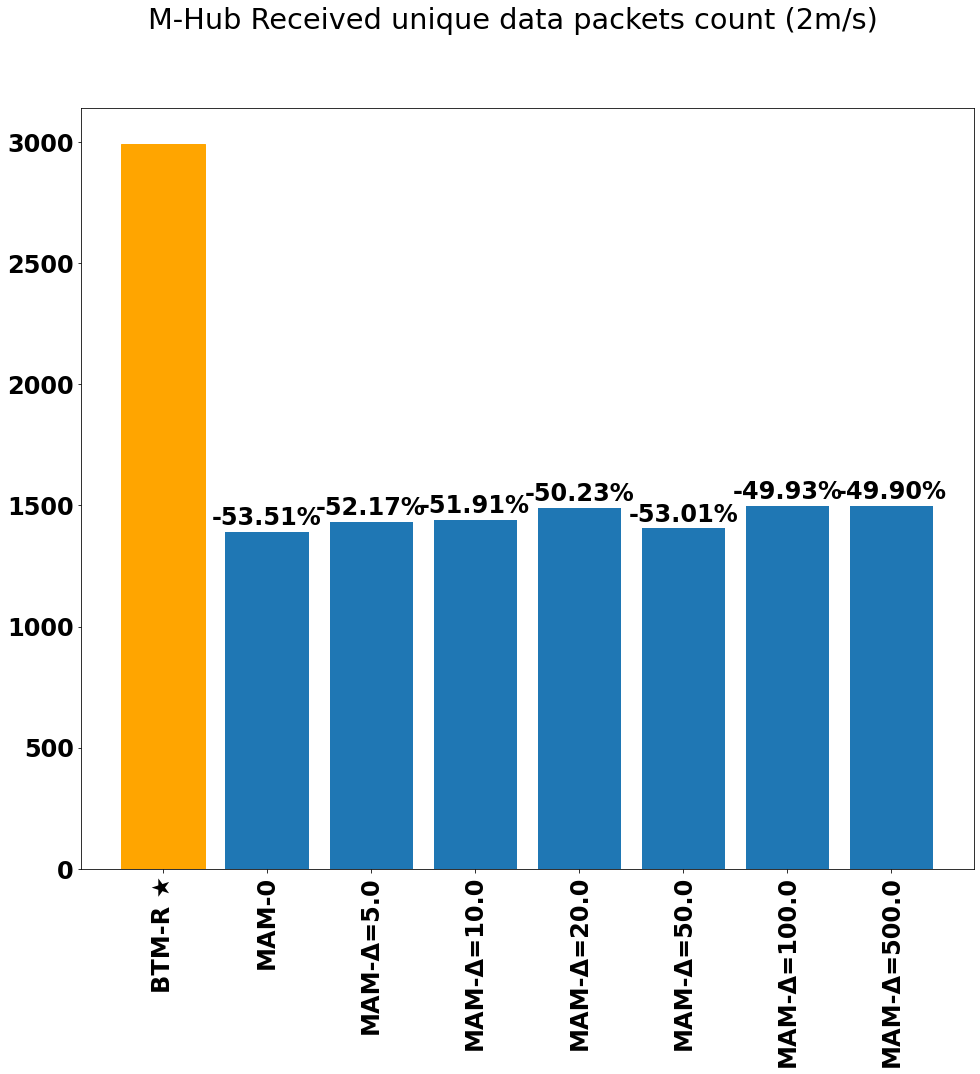

In [50]:
plotPacketsUniqueReceivedCount(labels, values, 2, 10)

In [51]:
[labels, values] = getCollectorPacketsUniqueReceivedCount(6)
getBarChartData(labels, values)

,label,value
0,BTM-R ★,1192
1,MAM-0,379
2,MAM-Δ=5.0,388
3,MAM-Δ=10.0,414
4,MAM-Δ=20.0,404
5,MAM-Δ=50.0,422
6,MAM-Δ=100.0,424
7,MAM-Δ=500.0,443


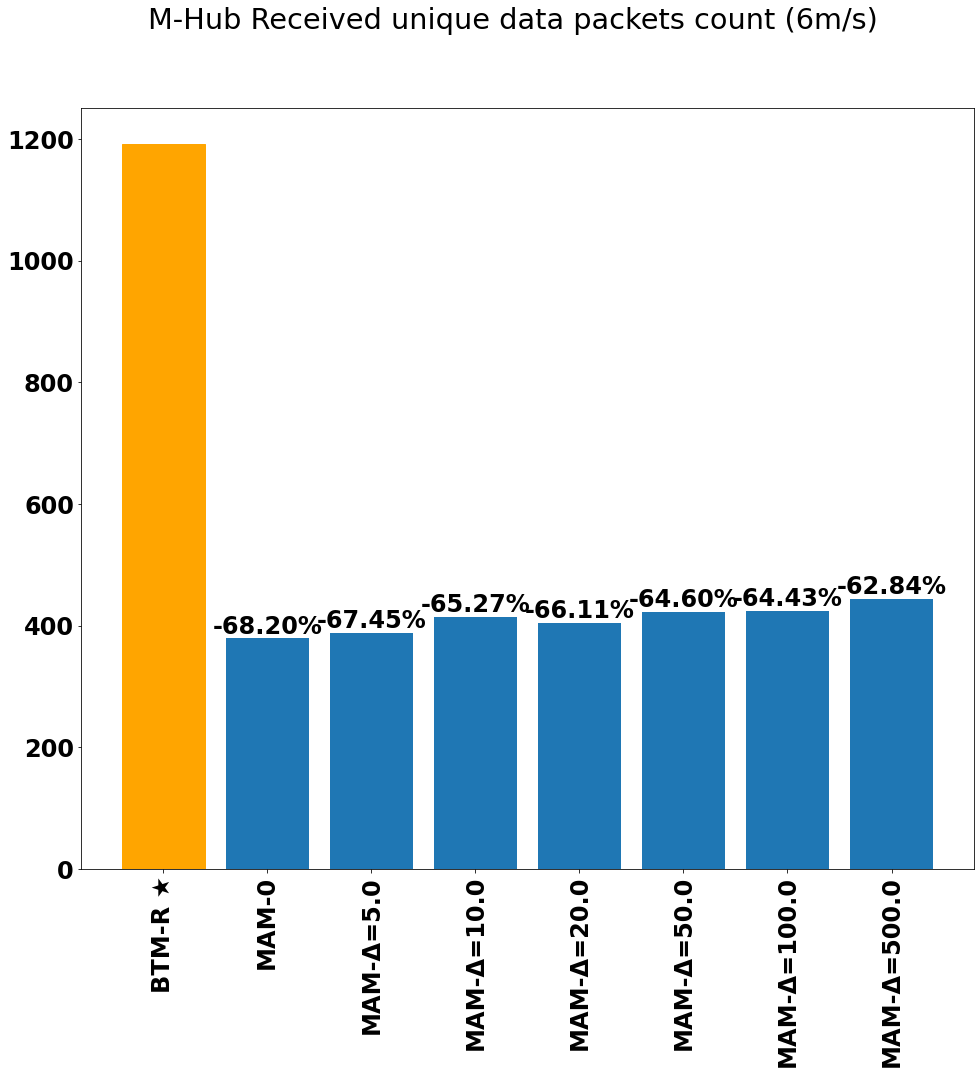

In [52]:
plotPacketsUniqueReceivedCount(labels, values, 6, 11)

In [53]:
[labels, values] = getCollectorPacketsUniqueReceivedCount(14)
getBarChartData(labels, values)

,label,value
0,BTM-R ★,2199
1,MAM-0,1004
2,MAM-Δ=5.0,972
3,MAM-Δ=10.0,952
4,MAM-Δ=20.0,1033
5,MAM-Δ=50.0,1151
6,MAM-Δ=100.0,965
7,MAM-Δ=500.0,1020


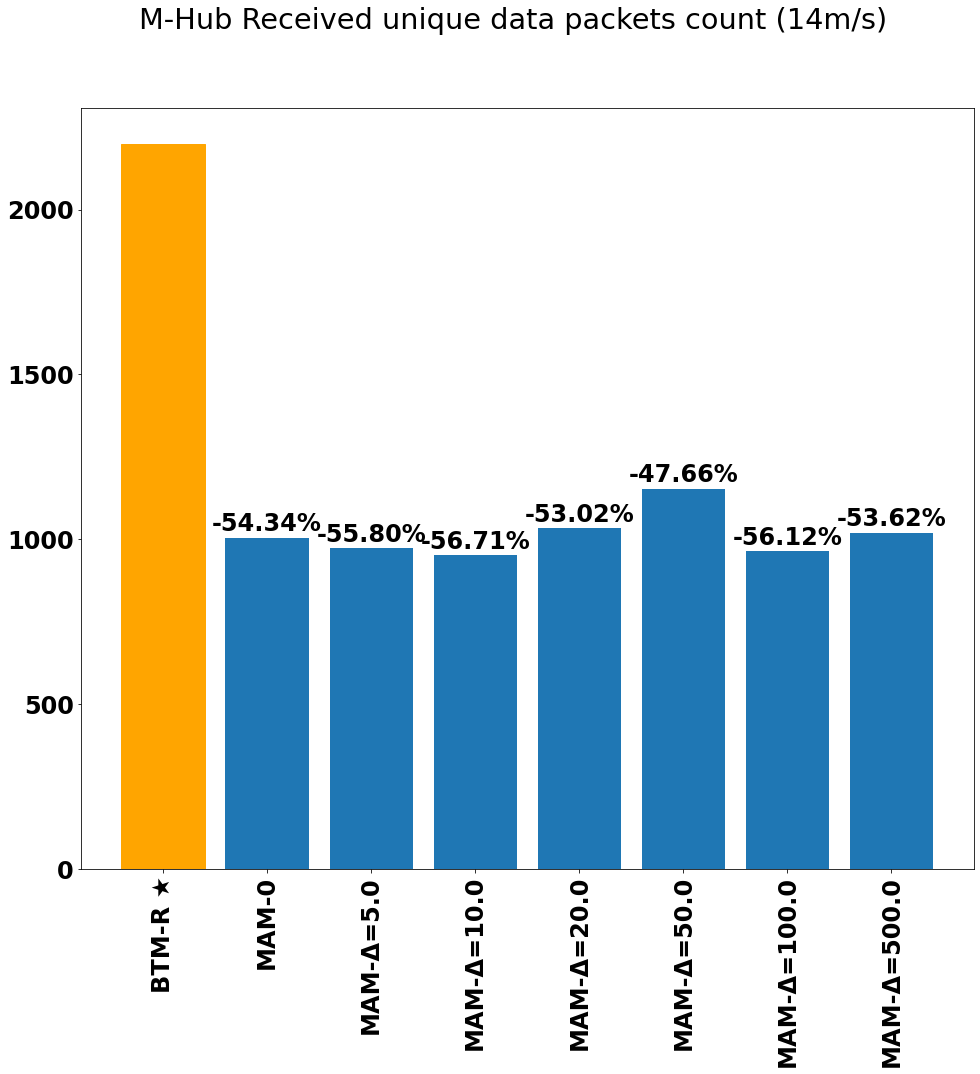

In [54]:
plotPacketsUniqueReceivedCount(labels, values, 14, 12)

In [55]:
def getCollectorPacketsUniqueDeliveryRate(speed):
    runData = getRunData(findBluetoothRelayRun(speed=speed, configName='MAM50-BMRELAY'))
    bmData = len(getReceivedPacketUUIDs(runData))/len(getGeneratedPacketUUIDs(runData))*100


    labels = ['BTM-R ★']
    values = [bmData]

    for d in allDeltas:
        runData = getRunData(findMAMRelayRun(speed=speed, delta=d, configName='MAM50-MAMRELAY'))
        values.append(len(getReceivedPacketUUIDs(runData))/len(getGeneratedPacketUUIDs(runData))*100)
        if d == 0:
            labels.append('MAM-0')
        else:
            labels.append('MAM-Δ=' + str(d))
    return [labels, values]

def plotPacketsUniqueDeliveryRate(labels, values, speed, imageIdx):
    # Create a figure instance
    fig = plt.figure(1, figsize=(16, 14))

    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the barchart
    bp = ax.bar(labels, values)
    bp[0].set_color('orange')

    i = 0
    for p in bp.patches:
        if i > 0:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy() 
            perc = (values[i]-values[0])/values[0]
            ax.annotate(f'{perc:.2%}', (x + width/2, y + height*1.02), ha='center')
        i = i + 1
        
    plt.suptitle('M-Hub delivery rate (uniqueDataReceived/uniqueDataGenerated) in % (' + str(speed) + 'm/s)')
    plt.xticks(rotation='90.0')

    # Save the figure
    fig.savefig('fig' + str(imageIdx) + '.png', bbox_inches='tight', dpi=150)

[labels, values] = getCollectorPacketsUniqueDeliveryRate(2)
getBarChartData(labels, values)

,label,value
0,BTM-R ★,8.525188
1,MAM-0,24.132547
2,MAM-Δ=5.0,24.465721
3,MAM-Δ=10.0,24.640411
4,MAM-Δ=20.0,25.553458
5,MAM-Δ=50.0,24.770965
6,MAM-Δ=100.0,26.336146
7,MAM-Δ=500.0,26.984698


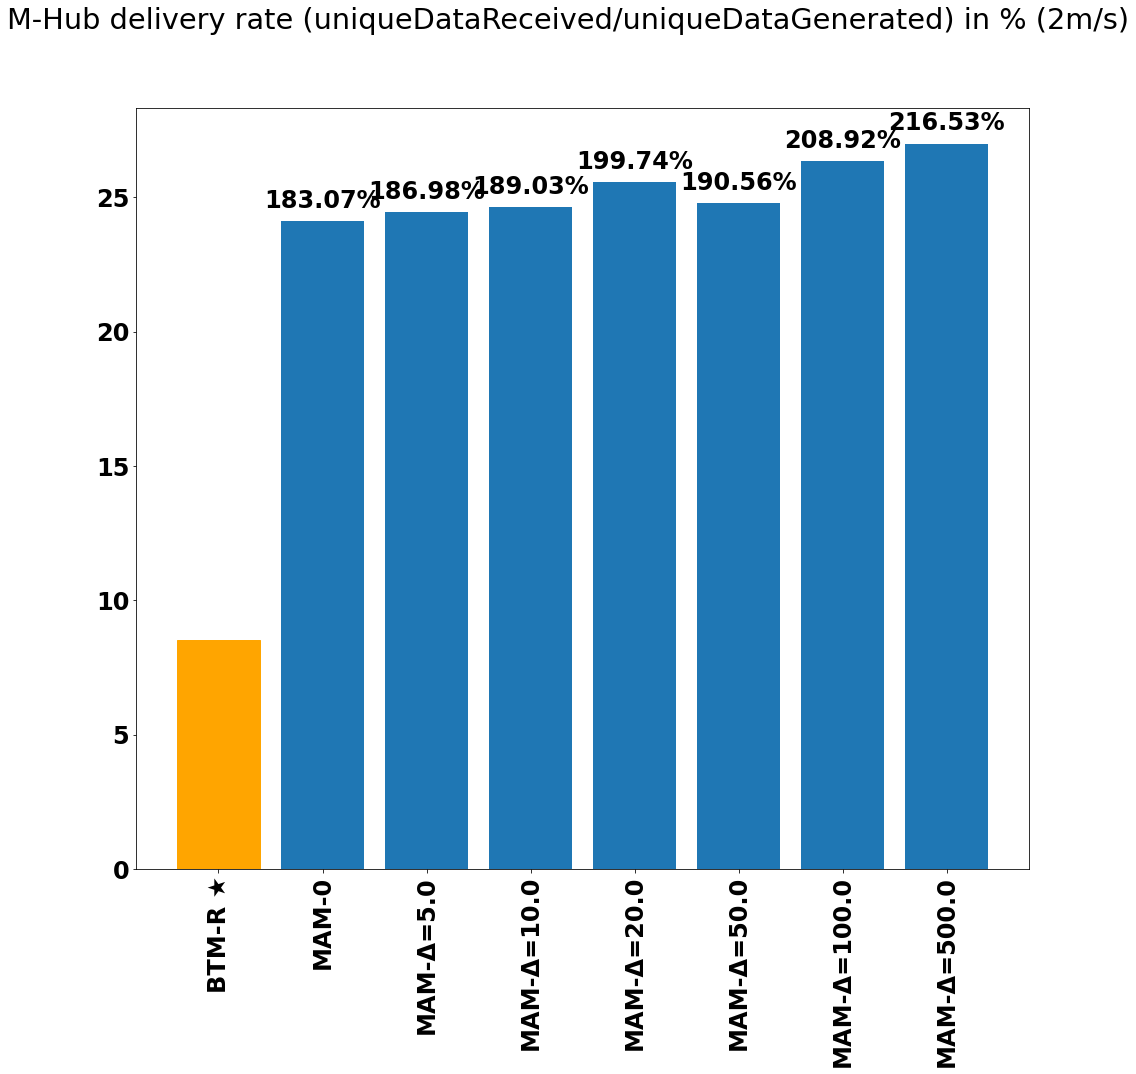

In [56]:
plotPacketsUniqueDeliveryRate(labels, values, 2, 13)

In [57]:
[labels, values] = getCollectorPacketsUniqueDeliveryRate(6)
getBarChartData(labels, values)

,label,value
0,BTM-R ★,3.572606
1,MAM-0,15.456770
2,MAM-Δ=5.0,17.344658
3,MAM-Δ=10.0,17.760618
4,MAM-Δ=20.0,16.057234
5,MAM-Δ=50.0,16.719493
6,MAM-Δ=100.0,18.354978
7,MAM-Δ=500.0,17.124082


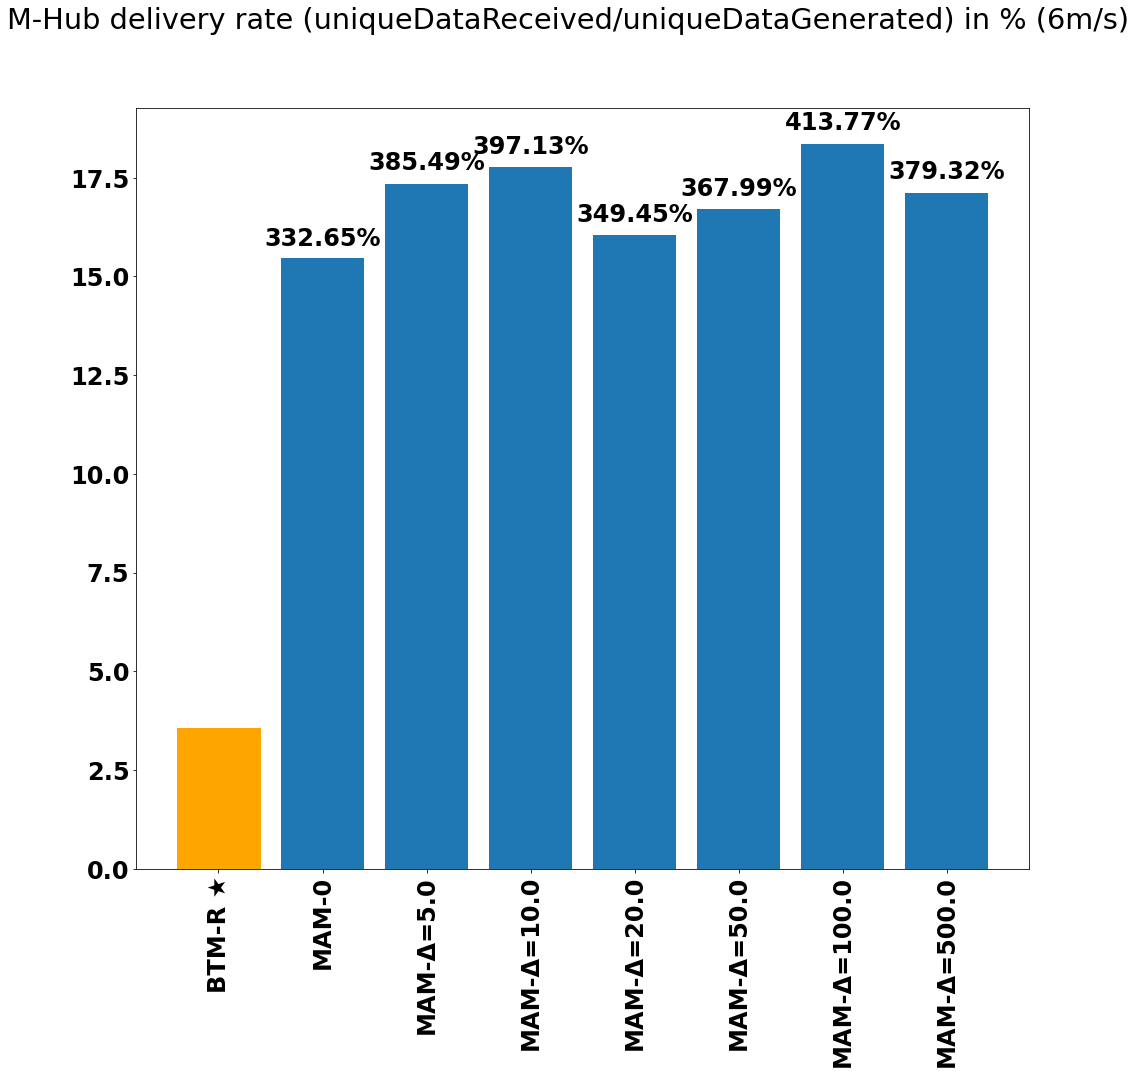

In [58]:

plotPacketsUniqueDeliveryRate(labels, values, 6, 14)

In [59]:
[labels, values] = getCollectorPacketsUniqueDeliveryRate(14)
getBarChartData(labels, values)

,label,value
0,BTM-R ★,6.813534
1,MAM-0,23.551490
2,MAM-Δ=5.0,24.089219
3,MAM-Δ=10.0,23.564356
4,MAM-Δ=20.0,24.420804
5,MAM-Δ=50.0,25.911751
6,MAM-Δ=100.0,23.485033
7,MAM-Δ=500.0,24.028269


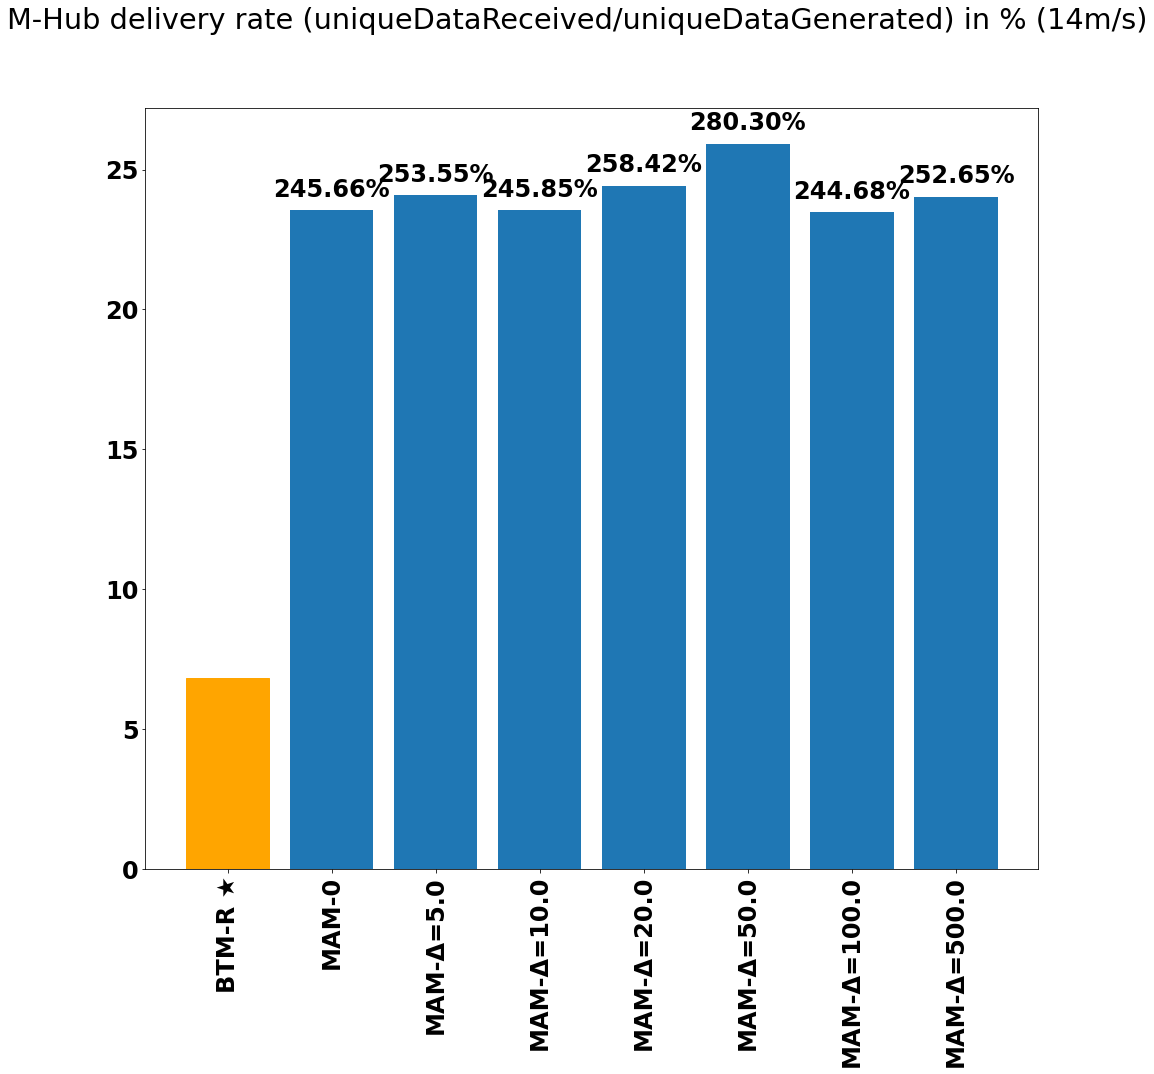

In [60]:

plotPacketsUniqueDeliveryRate(labels, values, 14, 15)